In [8]:
%matplotlib inline
import pylab as plt
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

## CoVid Data
Taken from
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

#### Infected data

In [126]:
import io
import requests

data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

proxy_dict = {
}

covid_data = pd.read_csv(io.StringIO(requests.get(data_url, proxies=proxy_dict).text), header=0)

In [132]:
total_numbers_with_china = [covid_data[date_col].sum() for date_col in covid_data.columns[4:]]
total_numbers_with_china_index = list(range(len(total_numbers_with_china)))
dates = pd.to_datetime(covid_data.columns[4:])

total_numbers_with_china_df = pd.DataFrame(data=total_numbers_with_china, columns=["infected (with China)"], index=dates)

covid_data_nonchina = covid_data[covid_data["Country/Region"] != "China"]

total_numbers = [covid_data_nonchina[date_col].sum() for date_col in covid_data_nonchina.columns[4:]]
total_numbers_index = list(range(len(total_numbers)))
dates = pd.to_datetime(covid_data_nonchina.columns[4:])

total_numbers_df = pd.DataFrame(data=total_numbers, columns=["infected"], index=dates)

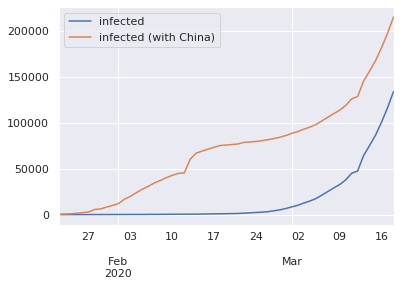

In [133]:
total_numbers_df.join(total_numbers_with_china_df).plot()

For now, we compute without China.

In [134]:
covid_data_by_country = covid_data.groupby("Country/Region").sum().transpose()[2:]
covid_data_by_country.index = pd.to_datetime(covid_data_by_country.index)

countries_with_the_most_infections = covid_data_by_country.sum(axis=0).sort_values()[-11:-1].index

Just as a side plot, the countries with the most infected people (except for China) have graphs that look like the following:

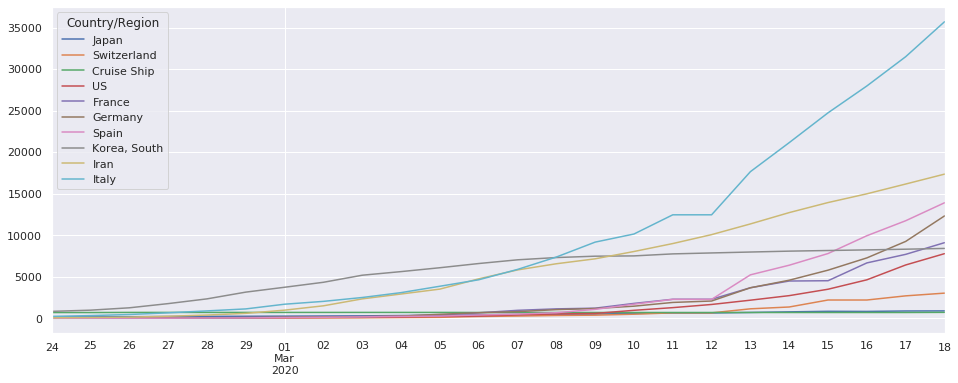

In [135]:
covid_data_by_country[countries_with_the_most_infections]["2020-02-24":].plot(figsize=(16, 6))

#### Only Germany

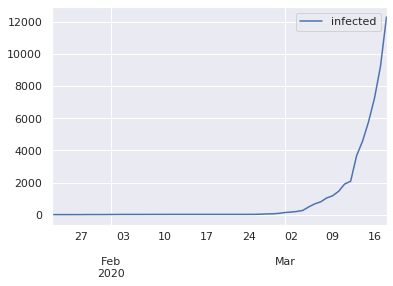

In [136]:
total_numbers_germany = covid_data_by_country["Germany"]

total_numbers_germany_df = pd.DataFrame(data=total_numbers_germany.values, columns=["infected"], index=total_numbers_germany.index)

total_numbers_germany_df.plot()

In [137]:
total_numbers_germany_df

,infected
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
2020-01-27,1.0
2020-01-28,4.0
2020-01-29,4.0
2020-01-30,4.0
2020-01-31,5.0


## Fit exp to current numbers
The infection curves above looks much like exponential curves.
As a first attempt, we will simply fit an exponential to the worldwide (minus China) infections.

In [138]:
def exp(x, base=2, offset=0):
    return base ** (np.array(x) - offset)

In [139]:
popt_exp, pcov = curve_fit(f=exp, xdata=total_numbers_index, ydata=total_numbers, p0=(3.5, -27))

popt_exp

array([  1.17215488, -18.43085907])

We can see that `popt[0]`, which is the estimated base parameter, is slightly above 1.
This means that each day we can find more people that have been infected.

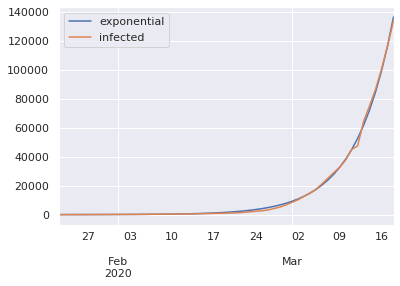

In [140]:
exponential_fit = pd.DataFrame(data=exp(total_numbers_index, *popt_exp), index=total_numbers_df.index, columns=["exponential"])

exponential_fit.join(total_numbers_df).plot()

In [165]:
mean_square_error = ((exponential_fit["exponential"] - total_numbers_df["infected"]) ** 2).mean()

mean_square_error

1306055.769623795

OK, that looks good. Let's extrapolate.

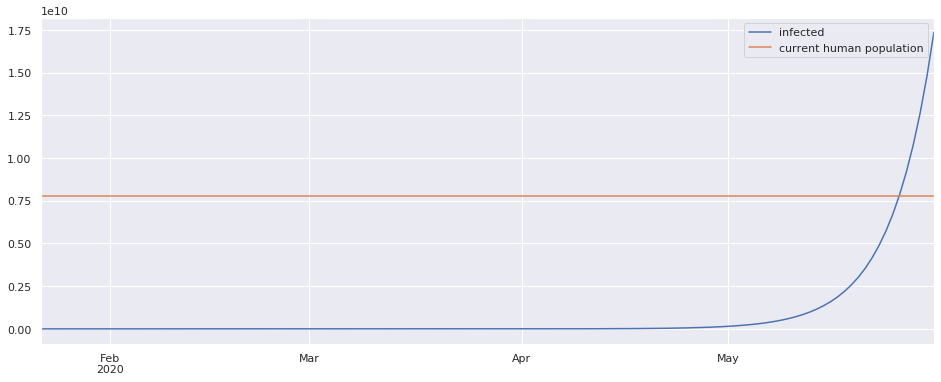

In [141]:
periods = int(2.3 * len(total_numbers))
predicted_cases_exponential = pd.DataFrame(columns=["infected"], data=exp(np.arange(0, periods), *popt_exp), index=pd.date_range(start=total_numbers_df.index[0], periods=periods, freq="1d"))
predicted_cases_exponential["current human population"] =  7771711072  # according to https://www.worldometers.info/world-population/

predicted_cases_exponential.plot(figsize=(16, 6))

Uh-oh. In late November, everyone on earth will be infected. Add 4 weeks and with a currently estimated mortality rate of 2-5% we will have lost 155 to 390 million people.

## Fit Sigmoid to current numbers

While at a first glance, the number of infections seems to grow exponentially, it is unrealistic that this might indeed be the case.
As proposed in https://www.spektrum.de/kolumne/die-covid-19-gleichung/1712714, a rational idea would be to fit a scaled sigmoid function to the number of infected people:
$$
\sigma_L(x, x_0, \lambda) = \frac{L}{1 + \exp^{- \lambda (x - x_0)}}
$$

In [142]:
def sigmoid(x, x0=0, lambd=1, L=1):
    return L / (1 + np.exp(-lambd * (x - x0)))

The sigmoid function graph looks like that:

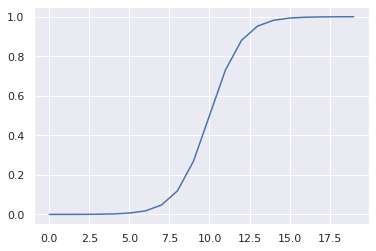

In [143]:
plt.plot(sigmoid(np.array(range(-10, 10))))

Intuitively, this is a more realistic approach, since there is a finite number of people on earth and even in the case that everybody will be infected at one point, the number of infected people will likely not grow exponential until then.

Let's fit that sigmoid curve to the infection curve.

In [144]:
popt, pcov = curve_fit(f=sigmoid, xdata=total_numbers_index, ydata=total_numbers)
popt

array([6.47456054e+01, 1.74108608e-01, 7.49535952e+05])

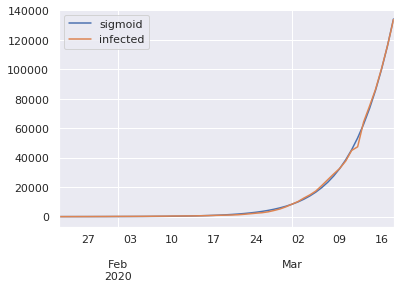

In [145]:
sigmoid_fit = pd.DataFrame(data=sigmoid(total_numbers_index, *popt), index=total_numbers_df.index, columns=["sigmoid"])

sigmoid_fit.join(total_numbers_df).plot()

In [164]:
mean_square_error = ((sigmoid_fit["sigmoid"] - total_numbers_df["infected"]) ** 2).mean()

mean_square_error

978301.9622558719

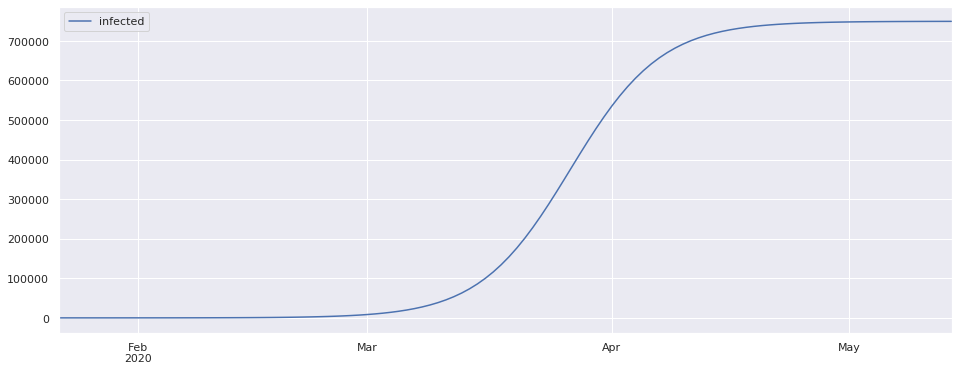

In [146]:
periods = 2 * len(total_numbers)
predicted_cases_sigmoid = pd.DataFrame(columns=["infected"], data=sigmoid(np.arange(0, periods), *popt), index=pd.date_range(start=total_numbers_df.index[0], periods=periods, freq="1d"))

predicted_cases_sigmoid.plot(figsize=(16, 6))

Now that looks much better. A maximum number of 900 000 infected people is a lot better than just everyone on earth.
Of course, that assumption only holds if the currently reported numbers are correct and precise.
This is however not the case, since there are many different testing methods and consequently different ways to identify infected persons.
In the end, this results in numbers that might even mean different things.
For now, we have to assume that these numbers are correct, as they are the best approximation to the status quo that we can get.

Let's assume that people get well again after about 4 weeks.

In [147]:
predicted_recoveries_sigmoid = pd.DataFrame(columns=["recovered"], data=predicted_cases_sigmoid.values, index=predicted_cases_sigmoid.index + pd.Timedelta(days=28))

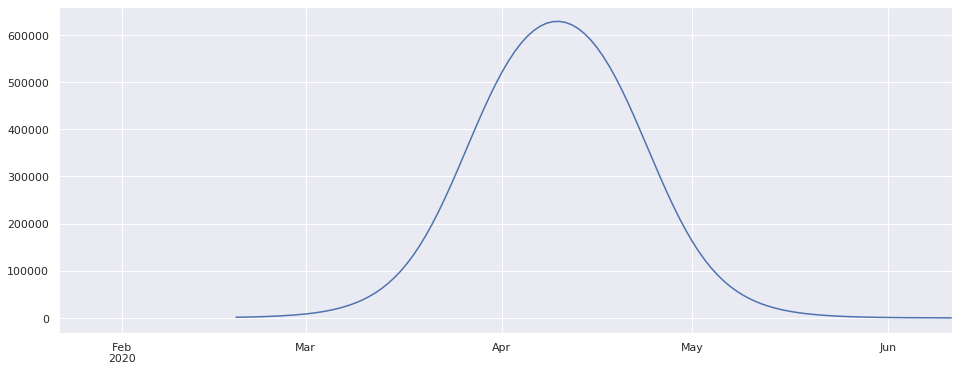

In [148]:
tmp_join_df = predicted_cases_sigmoid.join(predicted_recoveries_sigmoid, how="outer").ffill()
(tmp_join_df["infected"] - tmp_join_df["recovered"]).plot(figsize=(16, 6))

### Assuming an increased, unknown number of infected people

If everything would go well and there are no re-infections, we should be fine again in June.
Still, that's not something I'd believe in.

Let's ramp up the number of infected people by assuming that the current curve is (for now) indeed growing exponentially.
Additionally, we increase the grow rate from 1.17512793 to 1.18512793.

In [149]:
popt_exp

array([  1.17215488, -18.43085907])

In [158]:
popt_exp_dark = popt_exp # [1.17215488, -18.43085907]
total_numbers_dark = pd.DataFrame(data=exp(total_numbers_index, *popt_exp_dark), index=total_numbers_df.index, columns=["exponential"])

popt, pcov = curve_fit(f=sigmoid, xdata=total_numbers_index, ydata=total_numbers_dark["exponential"], maxfev=10000000)
popt

array([1.59720654e+02, 1.58843840e-01, 1.94886841e+12])

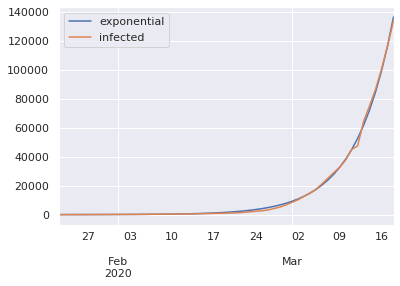

In [159]:
total_numbers_dark.join(total_numbers_df).plot()

The fitted sigmoid function looks like that:

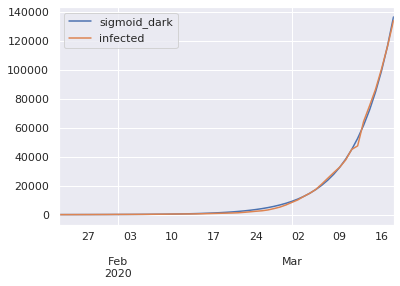

In [160]:
sigmoid_fit_dark = pd.DataFrame(data=sigmoid(total_numbers_index, *popt), index=total_numbers_df.index, columns=["sigmoid_dark"])

sigmoid_fit_dark.join(total_numbers_df).plot()

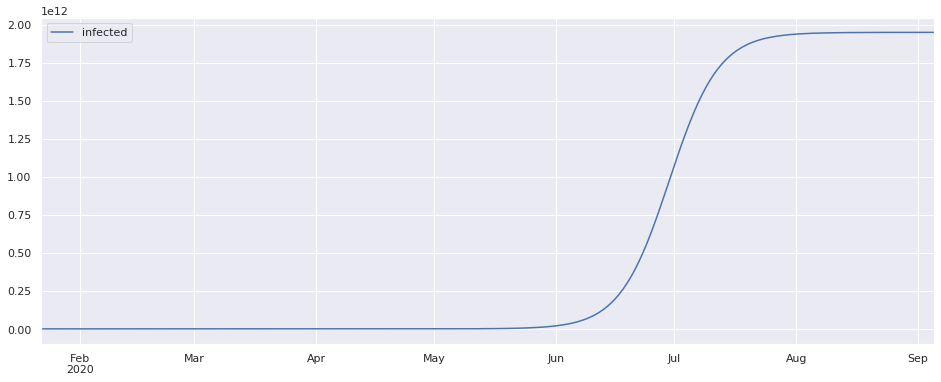

In [161]:
periods = 4 * len(total_numbers)
predicted_cases_sigmoid = pd.DataFrame(columns=["infected"], data=sigmoid(np.arange(0, periods), *popt), index=pd.date_range(start=total_numbers_df.index[0], periods=periods, freq="1d"))

predicted_cases_sigmoid.plot(figsize=(16, 6))

Well, this certainly looks less promising.
By simply increasing the estimated number of infected people, the saturation point of the sigmoid curve has now moved to the end of July!
Additionally, the maximal number of infected people has gone up to 3.5 billion, which certainly makes no sense at all.